In [18]:
import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree

In [3]:
df = pd.read_csv(r'C:\Users\prasr\Documents\Northeastern\IDMP\Project\reddit_sarcasm_detection\data\interim\parent_cleaned_sarcasm_with_sentiment.csv')
df = df.fillna('')
df = df[['label','comment','author','score','created_utc','parent_comment']]
df.head()

,label,comment,author,score,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,2,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,-4,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,3,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,-8,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,6,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Clean comments

In [4]:
stops = set(stopwords.words('english')) - {'no','not','nor','against','above','below','off','own'}
def clean_text(comment):
    text = str(comment)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ',text)
    text = re.sub("<.*?>", " ", text)
    text = re.sub(r"[0-9]+"," ",text)
    text = re.sub(r"@[A-Za-z0-9]+"," ",text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\'t", ' not',text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+',' ', text)
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    text = ' '.join(token for token in tokenizer.tokenize(text.lower()) if token not in stops)
    text = text.lower().strip()
    return text

df["cleaned_comment"] = df.swifter.apply(lambda x: clean_text(x["comment"]),axis=1)


Dask Apply: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


## Test train split

In [5]:
train_x, val_x,train_y , val_y = train_test_split(df.drop('label',axis=1),df['label'],random_state=123,test_size=0.20)

In [6]:
train_x.head()

,comment,author,score,created_utc,parent_comment,cleaned_comment
515596,IT WOULD ACTUALLY LET ME TECH IN LESS GRAVE ST...,KuroKitsu,-1,2015-07-17 02:15:56,I ACTUALLY WOULD LIKE THAT,would actually let tech less grave state depen...
839865,I hope that was,iMMinime,1,2014-06-19 20:53:36,You know shit is serious when game community i...,hope
361527,"Can I ask who you are supporting as a ""Serious...",JinxsLover,7,2016-02-28 04:45:58,I think there's enough people who recognize wh...,ask supporting serious mind cruz equally conce...
783999,What's Yahoo?,MINUS_Stl,2,2014-12-26 06:43:37,"Oh wow, I haven't been on yahoo in awhile. Did...",yahoo
476848,Brilliant observation.,PedanticWookiee,0,2016-03-18 22:24:11,Fitting username,brilliant observation


In [7]:
train_txt = train_x['cleaned_comment']
val_txt = val_x['cleaned_comment']

# TF-IDF & LogisticRegression (wt only comments)

In [7]:
# unigram and bigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=9000)
# X = vectorizer.fit_transform()
clf = LogisticRegression(random_state=123,n_jobs=6,verbose=1,max_iter = 500)

tfidf_log_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',clf)])


In [136]:
%%time
tfidf_log_reg_pipeline.fit(train_txt,train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   16.4s finished


Wall time: 32.3 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=9000, min_df=5,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(max_iter=500, n_jobs=6, random_state=123,
                                    verbose=1))])

In [137]:
%%time
val_predict = tfidf_log_reg_pipeline.predict(val_txt)
accuracy_score(val_y,val_predict)

Wall time: 1.66 s


0.6832358722970114

<AxesSubplot:>

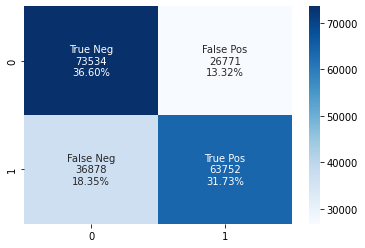

In [138]:
def plot_conf_mat(val_y,val_predict):
    log_regression_conf_mat = confusion_matrix(val_y,val_predict)
    # sn.heatmap(log_regression_conf_mat, annot=True,cmap='Blues')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    log_regression_conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        log_regression_conf_mat.flatten()/np.sum(log_regression_conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(log_regression_conf_mat, annot=labels, fmt='', cmap='Blues')
plot_conf_mat(val_y,val_predict)

# TF_IDF & Logistic Regression (Wt parent & child comment)

In [119]:
df["cleaned_parent_comment"] = df.swifter.apply(lambda x: clean_text(x["parent_comment"]),axis=1)
df['cleaned_parent_child_comment'] = df['cleaned_parent_comment'] +' '+ df['cleaned_comment']
df.head()

Dask Apply: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


,label,comment,author,score,created_utc,parent_comment,cleaned_comment,cleaned_parent_comment,cleaned_parent_child_comment
0,0,NC and NH.,Trumpbart,2,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",nc nh,yeah get argument point would prefer lived nc ...,yeah get argument point would prefer lived nc ...
1,0,You do know west teams play against west teams...,Shbshb906,-4,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,know west teams play against west teams east t...,blazers mavericks wests seed not even carry go...,blazers mavericks wests seed not even carry go...
2,0,"They were underdogs earlier today, but since G...",Creepeth,3,2016-09-22 21:45:37,They're favored to win.,underdogs earlier today since gronk announceme...,favored win,favored win underdogs earlier today since gron...
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,-8,2016-10-18 21:03:47,deadass don't kill my buzz,meme not funny none new york nigga ones,deadass not kill buzz,deadass not kill buzz meme not funny none new ...
4,0,I could use one of those tools.,cush2push,6,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,could use one tools,yep confirm saw tool use made boy easports mut,yep confirm saw tool use made boy easports mut...


In [120]:
train_x, val_x,train_y , val_y = train_test_split(df.drop('label',axis=1),df['label'],random_state=123,test_size=0.20)
train_txt = train_x['cleaned_parent_child_comment']
val_txt = val_x['cleaned_parent_child_comment']

In [121]:
%%time
# bigram and trigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=15000)
clf = LogisticRegression(random_state=123,n_jobs=6,verbose=1,max_iter = 500)

tfidf_log_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',clf)])

tfidf_log_reg_pipeline.fit(train_txt,train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   10.0s finished


Wall time: 56.9 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=15000, min_df=10,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(max_iter=500, n_jobs=6, random_state=123,
                                    verbose=1))])

In [122]:
%%time
val_predict = tfidf_log_reg_pipeline.predict(val_txt)
accuracy_score(val_y,val_predict)

Wall time: 4.61 s


0.6568940204543758

In [14]:
plot_conf_mat(val_y,val_predict)

# TF-IDF & Decision tree


In [24]:
# unigram and bigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=9000)
# X = vectorizer.fit_transform()
dt = tree.DecisionTreeClassifier(max_depth=256,criterion="entropy",splitter="random")

tfidf_dt_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',dt)])

In [25]:
%%time
tfidf_dt_reg_pipeline.fit(train_txt,train_y)

Wall time: 6min 51s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=9000, min_df=5,
                                 ngram_range=(1, 2))),
                ('logit',
                 DecisionTreeClassifier(criterion='entropy', max_depth=256,
                                        splitter='random'))])

In [26]:
%%time
val_predict = tfidf_dt_reg_pipeline.predict(val_txt)
accuracy_score(val_y,val_predict)

Wall time: 1.79 s


0.6415905641127728

# TF-IDF & Random Forest

In [38]:
# unigram and bigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 6,max_features = 12000)

rf = RandomForestClassifier(max_depth = 512, n_estimators = 380, random_state = 123, n_jobs = 6, verbose = 1)

tfidf_rf_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',rf)])

In [39]:
%%time
tfidf_rf_reg_pipeline.fit(train_txt,train_y)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 71.9min


Wall time: 2h 22min 2s


[Parallel(n_jobs=6)]: Done 380 out of 380 | elapsed: 141.8min finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=12000, min_df=6,
                                 ngram_range=(1, 2))),
                ('logit',
                 RandomForestClassifier(max_depth=512, n_estimators=380,
                                        n_jobs=6, random_state=123,
                                        verbose=1))])

In [40]:
%%time
val_predict = tfidf_rf_reg_pipeline.predict(val_txt)
accuracy_score(val_y,val_predict)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    8.4s


Wall time: 19.8 s


[Parallel(n_jobs=6)]: Done 380 out of 380 | elapsed:   17.3s finished


0.6775673725334064

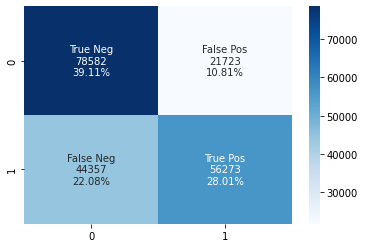

In [36]:
plot_conf_mat(val_y,val_predict)

In [50]:
# TODO svm, random forest, decision tree, xgboost using Hyperopt .

In [51]:
# TODO run cnn model
